<a href="https://colab.research.google.com/github/Wondav/Data-Analysis/blob/main/Model_Improvement.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import joblib
import optuna
from sklearn.model_selection import StratifiedKFold,cross_val_score
from sklearn.preprocessing import PolynomialFeatures
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score

In [2]:
data=pd.read_csv("data_cleaned.csv")
data.head()

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status,Loan_ID
0,1.0,0.0,0.0,1.0,0.0,5849.0,0.0,148.0,360.0,1.0,2.0,1.0,LP001002
1,1.0,1.0,1.0,1.0,0.0,4583.0,1508.0,128.0,360.0,1.0,0.0,0.0,LP001003
2,1.0,1.0,0.0,1.0,1.0,3000.0,0.0,66.0,360.0,1.0,2.0,1.0,LP001005
3,1.0,1.0,0.0,0.0,0.0,2583.0,2358.0,120.0,360.0,1.0,2.0,1.0,LP001006
4,1.0,0.0,0.0,1.0,0.0,6000.0,0.0,141.0,360.0,1.0,2.0,1.0,LP001008


## Feature Engineering

In [3]:
poly=PolynomialFeatures(degree=2, interaction_only=True,include_bias=False)

data['TotalIncome']=data['ApplicantIncome']+data['CoapplicantIncome']
data['IncomeByLoan']=data['TotalIncome']/data['LoanAmount']
data['ApplicantByLoan']=data['ApplicantIncome']/data['LoanAmount']
data['CoapplicantByLoan']=data['CoapplicantIncome']/data['LoanAmount']
data['LoanByTerm']=data['LoanAmount']/data['Loan_Amount_Term']


poly1=poly.fit_transform(data[['ApplicantIncome','CoapplicantIncome','LoanAmount','TotalIncome','IncomeByLoan','ApplicantByLoan','CoapplicantByLoan','LoanByTerm']])
df_poly=pd.DataFrame(poly1, columns=[f'poly_{i}' for i in range(poly1.shape[1])])


In [4]:
new_data=pd.concat([data,df_poly],axis=1)

In [5]:
X=new_data.drop(['Loan_ID','Loan_Status'],axis=1)
y=new_data['Loan_Status']

## Model Development

In [6]:
fold=StratifiedKFold(n_splits=5)

F1,i=[],1
for train, test in fold.split(X,y):
    X_train, X_test = X.iloc[train],X.iloc[test]
    y_train, y_test = y.iloc[train],y.iloc[test]
    
    cat=CatBoostClassifier(verbose=False)
    
    cat.fit(X_train,y_train)
    
    preds=cat.predict(X_test)
    
    print(f'Accuracy, fold_{i}: {accuracy_score(y_test,preds)}')
    i+=1
    F1.append(accuracy_score(y_test,preds))
print(np.mean(F1))

Accuracy, fold_1: 0.8130081300813008
Accuracy, fold_2: 0.8048780487804879
Accuracy, fold_3: 0.7804878048780488
Accuracy, fold_4: 0.8536585365853658
Accuracy, fold_5: 0.819672131147541
0.8143409302945489


## Feature Selection

Text(0.5, 1.0, 'Model features importance:')

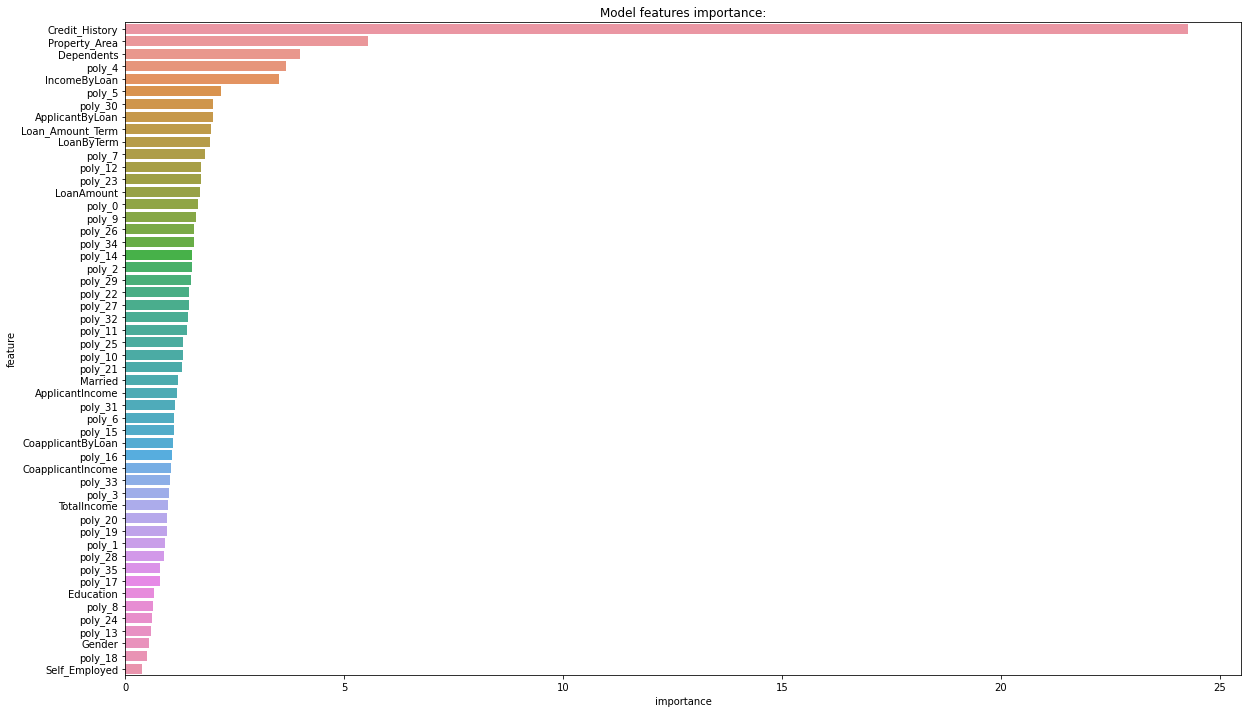

In [7]:
# 0.7831404345536787
feature_importance_df = pd.DataFrame(cat.feature_importances_, columns=['importance'])
feature_importance_df['feature'] = new_data.drop(['Loan_ID','Loan_Status'],axis=1).columns

plt.figure(figsize=(20, 12))
sns.barplot(x="importance", y="feature", data=feature_importance_df.sort_values(by = ['importance'], ascending = False).head(60))
plt.title('Model features importance:')

In [8]:
cat_feat = feature_importance_df.sort_values(by = ['importance'], ascending = False).head(30)['feature'].to_list()

In [9]:
X= new_data[cat_feat]

## Hyperparameter Optimization

In [10]:
def objective(trial):
    oof_f1=[]
    oof_predictions=[]


    param = {}
    param['learning_rate'] = trial.suggest_discrete_uniform("learning_rate", 0.001, 0.1, 0.001)
    param['depth'] = trial.suggest_int('depth', 3, 15)
    param['l2_leaf_reg'] = trial.suggest_discrete_uniform('l2_leaf_reg', 1.0, 5.5, 0.5)
    param['min_child_samples'] = trial.suggest_categorical('min_child_samples', [1, 4, 8, 16, 32])
    param['iterations'] = trial.suggest_discrete_uniform("iterations", 200, 4000, 50)
    param["colsample_bylevel"] =  trial.suggest_float("colsample_bylevel", 0.01, 0.1)
    param['random_state'] = 0
    param['scale_pos_weight'] = trial.suggest_int('scale_pos_weight', 1, 10)
    param['bootstrap_type'] = trial.suggest_categorical("bootstrap_type", ["Bayesian", "Bernoulli", "MVS"])
    param['logging_level'] = 'Silent'



    fold=StratifiedKFold(n_splits=5)
    i=1
    for train_index, test_index in fold.split(X,y):
        
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        cat = CatBoostClassifier(**param)
    

        cat.fit(X_train,y_train,eval_set=[(X_train,y_train),(X_test, y_test)], early_stopping_rounds=100, verbose = False)#erly100
        preds=cat.predict(X_test)

        oof_f1.append(accuracy_score(y_test,preds))

    return np.mean(oof_f1)

In [11]:
optuna.logging.set_verbosity(optuna.logging.WARNING)

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

In [12]:
print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Number of finished trials: 100
Best trial:
  Value: 0.8257363721178196
  Params: 
    learning_rate: 0.025
    depth: 3
    l2_leaf_reg: 1.0
    min_child_samples: 32
    iterations: 1650.0
    colsample_bylevel: 0.09791445180073374
    scale_pos_weight: 1
    bootstrap_type: MVS


In [18]:
model = CatBoostClassifier(**study.best_params, verbose=False)

In [19]:
model.fit(X,y)

In [20]:
joblib.dump(model, 'cat_loan')

['cat_loan']